In this botebook, I will check the correlation of ancestry and heterozygosity in the samples.
It requires the df saved in rfmix3

In [1]:
%run ../scripts/notebook_settings_lean.py
import allel
import zarr
from scipy import stats
from horizonplot import horizonplot

In [2]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
meta_data_samples_Sci = meta_data_samples.copy()
for i, row in meta_data_samples_Sci.iterrows():
    if row.PGDP_ID[0] != "P":
        meta_data_samples_Sci.at[i, "PGDP_ID"] = "Sci_"+str(row.PGDP_ID)
females = meta_data_samples_Sci.loc[meta_data_samples_Sci.Sex == "F"].reset_index()

out_dir = "../steps/het_windows/"

In [3]:
window_size = 100000
chromosomes = [f'chr{x}' for x in range(1, 21)] + ['chrX']

def het_counting(gt):
    return gt.count_het()

os.makedirs(out_dir, exist_ok = True)
chr_df_list = []
for chrom in chromosomes:
    df_list = []
    zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/{}".format(chrom)
    callset = zarr.open_group(zarr_dir, mode='r')
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    for i, row in meta_data_samples.iterrows():
        df = pd.DataFrame()
        individual = (gt.take([row.callset_index], axis=1))
        nnz, windows, counts = allel.windowed_statistic(pos, individual, statistic=het_counting, size=window_size)
        df["het"] = nnz
        df["sex"] = row.Sex
        if i % 50 == 0:
            print(i)
        window_numbering = []
        df.insert(0, column="chrom", value=chrom)
        window_numbering.extend(range(len(nnz)))
        df.insert(1, column="start", value=window_numbering)
        df.insert(2, column = "pop", value = row.PGDP_ID)
        df_list.append(df)
    chr_df = pd.concat(df_list, axis=0)
    chr_df_list.append(chr_df)
    #chr_df.to_csv(out_dir + "het_counts_windows_{}.txt".format(chrom), sep = " ", index=False)
    print("Finished with {}".format(chrom))

0
50
100
150
200
Finished with chr1
0
50
100
150
200
Finished with chr2
0
50
100
150
200
Finished with chr3
0
50
100
150
200
Finished with chr4
0
50
100
150
200
Finished with chr5
0
50
100
150
200
Finished with chr6
0
50
100
150
200
Finished with chr7
0
50
100
150
200
Finished with chr8
0
50
100
150
200
Finished with chr9
0
50
100
150
200
Finished with chr10
0
50
100
150
200
Finished with chr11
0
50
100
150
200
Finished with chr12
0
50
100
150
200
Finished with chr13
0
50
100
150
200
Finished with chr14
0
50
100
150
200
Finished with chr15
0
50
100
150
200
Finished with chr16
0
50
100
150
200
Finished with chr17
0
50
100
150
200
Finished with chr18
0
50
100
150
200
Finished with chr19
0
50
100
150
200
Finished with chr20
0
50
100
150
200
Finished with chrX


In [4]:
chr_df_all = pd.concat(chr_df_list)

In [5]:
chr_df_all["individuals"] = chr_df_all["pop"].map(dict(zip(meta_data_samples.PGDP_ID,
                                                           meta_data_samples_Sci.PGDP_ID)))
chr_df_all.to_csv(out_dir + "het_windows_all.txt", index = False)

Loading in the saved df

In [6]:
chr_df_all = pd.read_csv(out_dir + "het_windows_all.txt")
window_df = pd.read_csv("../steps/rfmix_v1_windowed_df.txt")

In [21]:
chr_df_all.loc[chr_df_all.individuals.isin(window_df.individual.unique())]

,chrom,start,pop,het,sex,individuals
0,chr1,0,16066,176,F,Sci_16066
1,chr1,1,16066,95,F,Sci_16066
2,chr1,2,16066,133,F,Sci_16066
3,chr1,3,16066,73,F,Sci_16066
4,chr1,4,16066,541,F,Sci_16066
...,...,...,...,...,...,...
6186969,chrX,1432,PD_0774,3,F,PD_0774
6186970,chrX,1433,PD_0774,4,F,PD_0774
6186971,chrX,1434,PD_0774,0,F,PD_0774
6186972,chrX,1435,PD_0774,11,F,PD_0774


Both dataframes are sorted with individuals > chrom, so I can just insert the het measure.

In [54]:
het_series = chr_df_all.loc[chr_df_all.individuals.isin(window_df.individual.unique())].reset_index().het
het_series

0          176
1           95
2          133
3           73
4          541
          ... 
2053645      3
2053646      4
2053647      0
2053648     11
2053649    100
Name: het, Length: 2053650, dtype: int64

In [55]:
window_df["het"] = het_series

Something strange happens (it was due to differences in index). Fixed

In [57]:
sum(chr_df_all.loc[chr_df_all.individuals.isin(window_df.individual.unique())].isna().het), sum(window_df.isna().het)

(0, 0)

In [58]:
chr_df_all.loc[chr_df_all.individuals.isin(window_df.individual.unique())]

,chrom,start,pop,het,sex,individuals
0,chr1,0,16066,176,F,Sci_16066
1,chr1,1,16066,95,F,Sci_16066
2,chr1,2,16066,133,F,Sci_16066
3,chr1,3,16066,73,F,Sci_16066
4,chr1,4,16066,541,F,Sci_16066
...,...,...,...,...,...,...
6186969,chrX,1432,PD_0774,3,F,PD_0774
6186970,chrX,1433,PD_0774,4,F,PD_0774
6186971,chrX,1434,PD_0774,0,F,PD_0774
6186972,chrX,1435,PD_0774,11,F,PD_0774


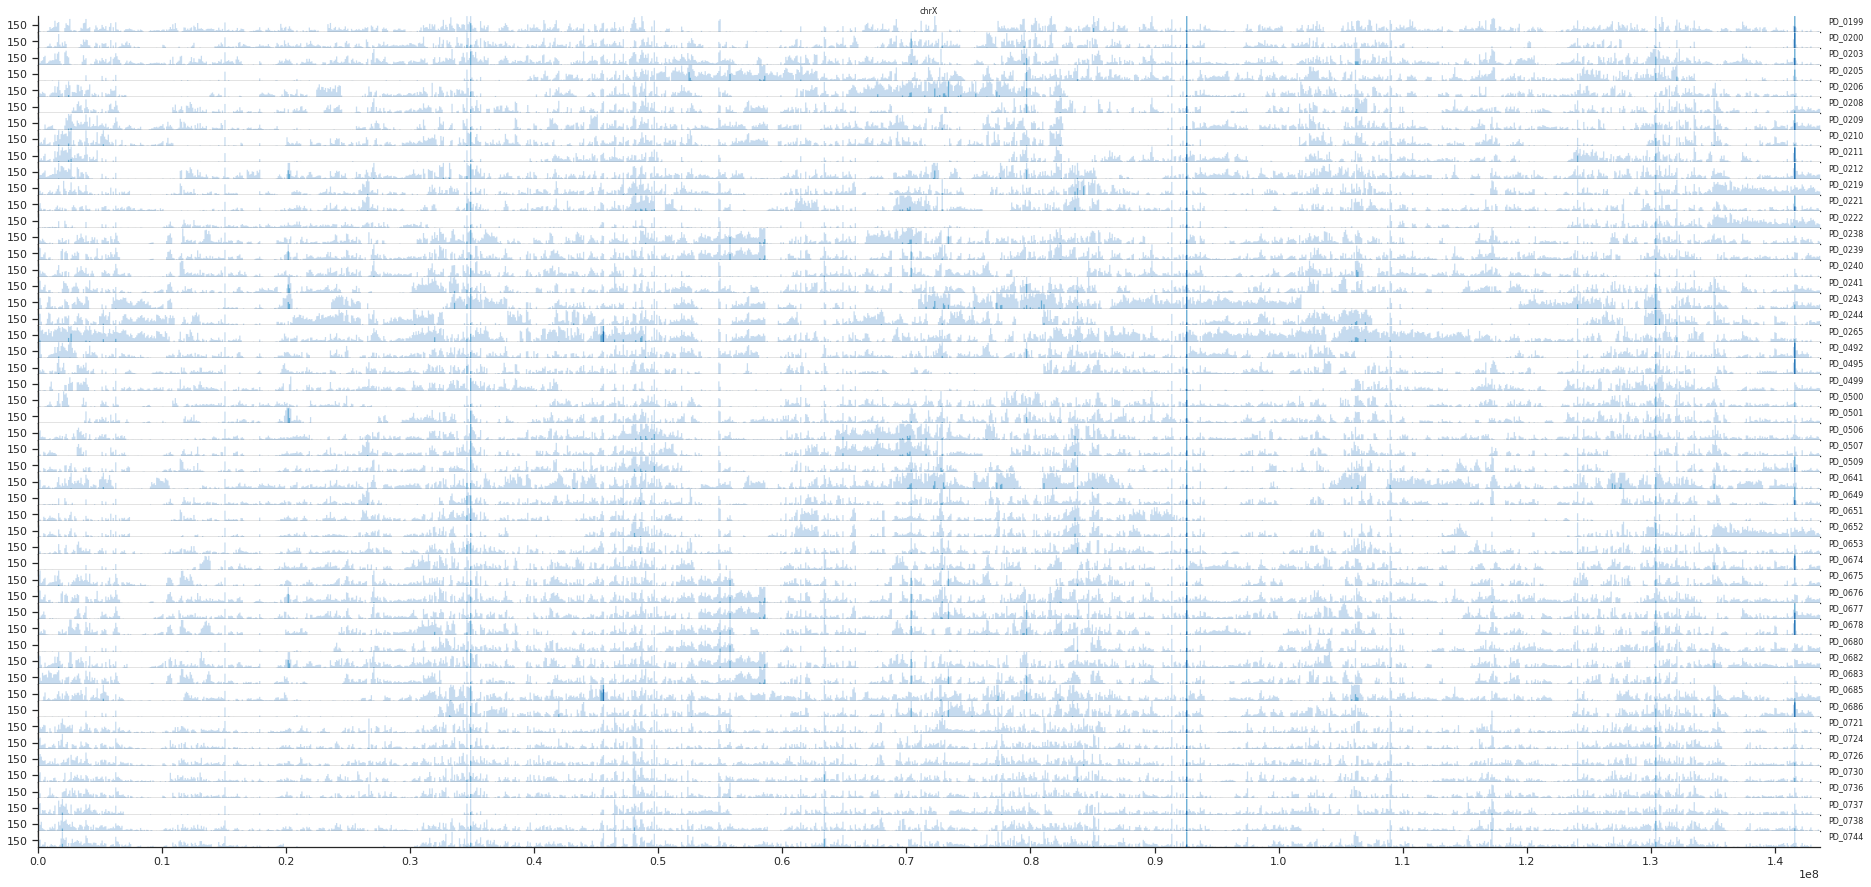

In [61]:
anubis = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "anubis"].PGDP_ID)]
chrX = anubis.loc[anubis.chrom == "chrX"]
fig = horizonplot(chrX, 'het', width=2, col='chrom', row='individual', size=0.3, aspect=100)

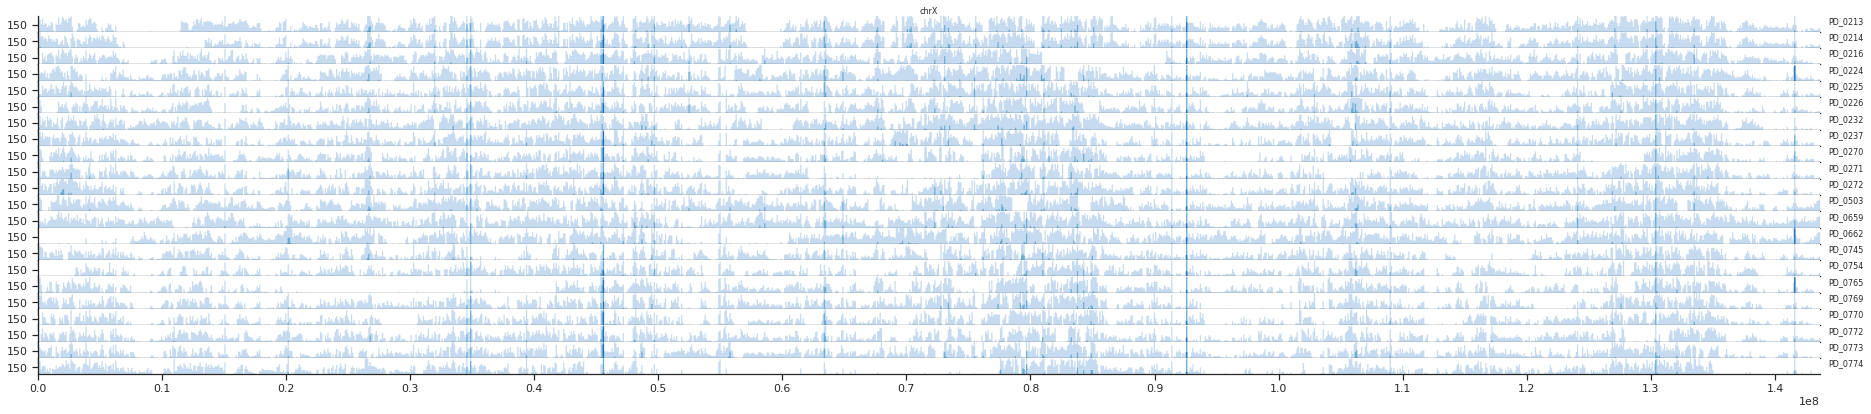

In [67]:
yellow = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "cynocephalus"].PGDP_ID)]
chrX = yellow.loc[yellow.chrom == "chrX"]
fig = horizonplot(chrX, 'het', width=2, col='chrom', row='individual', size=0.3, aspect=100)

In [87]:
grouped_df = window_df.groupby(["individual", "chrom"]).mean().reset_index()
grouped_df_sub = grouped_df[["individual", "chrom"]]
grouped_df_sub["mean_het"] = grouped_df.het
window_df = window_df.merge(grouped_df_sub)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
window_df["norm_het"] = window_df.het / window_df.mean_het

Check of norm plot

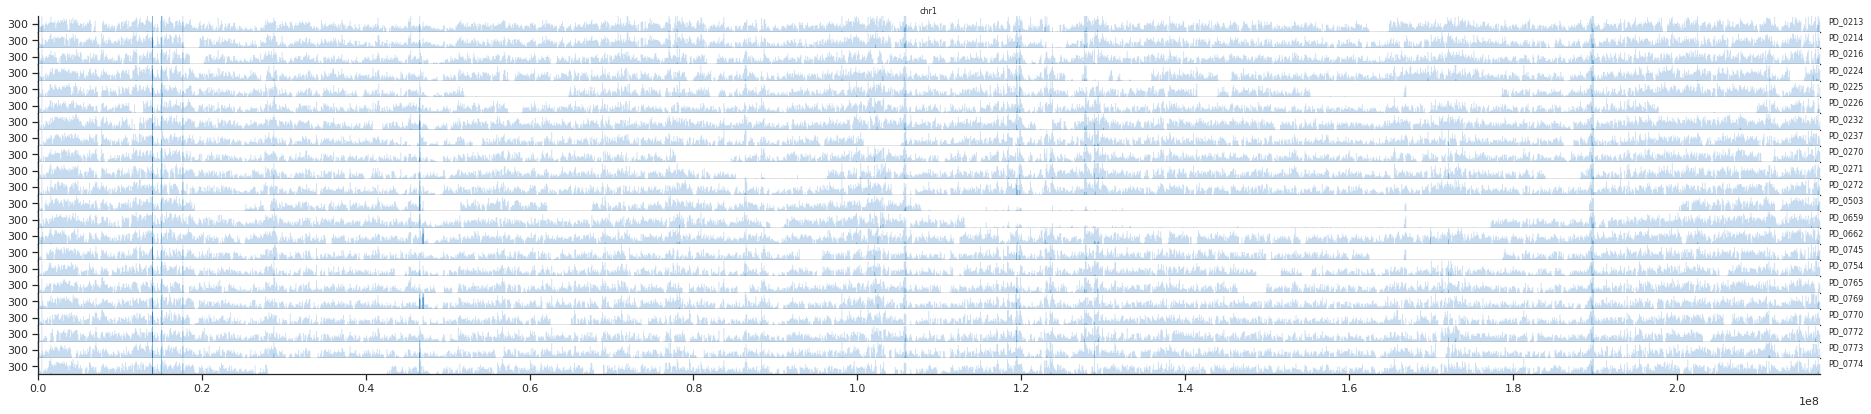

In [92]:
yellow = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "cynocephalus"].PGDP_ID)]
chr1 = yellow.loc[yellow.chrom == "chr1"]
fig = horizonplot(chr1, 'het', width=2, col='chrom', row='individual', size=0.3, aspect=100)

<AxesSubplot:xlabel='norm_north', ylabel='Count'>

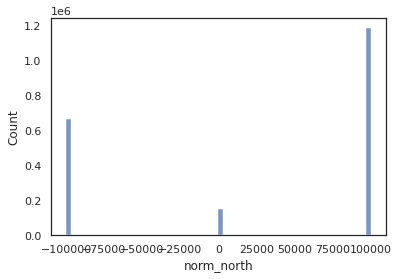

In [98]:
sns.histplot(window_df.norm_north)

In [103]:
window_df["state"] = ["south" if x < -25000 else "north" if x > 25000 else "mixed" for x in window_df.norm_north]

In [104]:
window_df.state.unique()

array(['south', 'north', 'mixed'], dtype=object)

<AxesSubplot:xlabel='norm_het', ylabel='Count'>

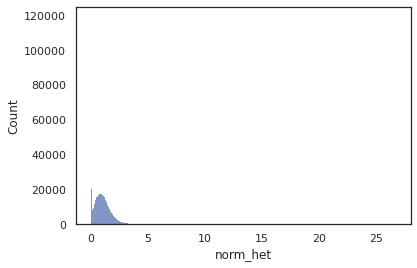

In [95]:
sns.histplot(data = window_df, x="norm_het")

[(-0.1, 4.0)]

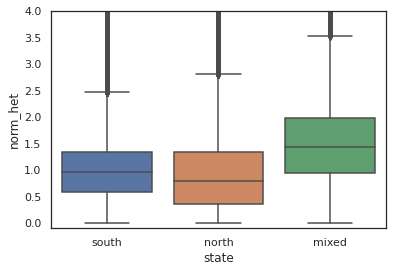

In [118]:
g = sns.boxplot(data = window_df, x="state", y="norm_het")
g.set(ylim=(-0.1, 4))

[(-0.1, 4.0)]

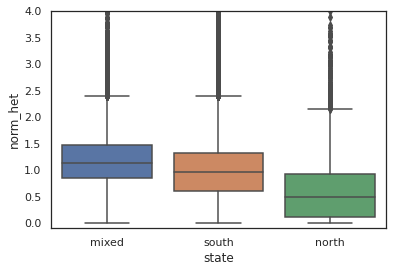

In [120]:
yellow = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "cynocephalus"].PGDP_ID)]
g = sns.boxplot(data = yellow, x="state", y="norm_het")
g.set(ylim=(-0.1, 4))

[(-0.1, 4.0)]

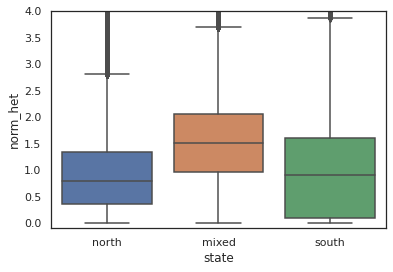

In [119]:
anubis = window_df.loc[window_df.individual.isin(meta_data_samples.loc[meta_data_samples.Species
                                                                     == "anubis"].PGDP_ID)]
g = sns.boxplot(data = anubis, x="state", y="norm_het")
g.set(ylim=(-0.1, 4))

[(-0.1, 4.0), (0.0, 30000.0)]

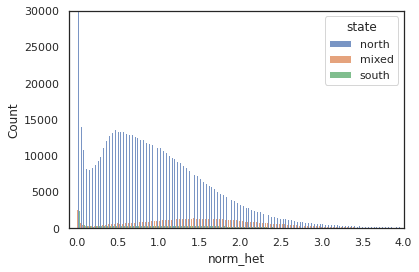

In [127]:
g = sns.histplot(data=anubis, x="norm_het", hue="state", multiple="dodge")
g.set(xlim=(-0.1, 4), ylim=(None, 30000))